<a href="https://colab.research.google.com/github/j0ngle/Machine-Learning-Projects/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Convolutional Generative Adverserial Network (DGCAN) designed to learn to replicate landscape paintings from [this](https://www.kaggle.com/ipythonx/wikiart-gangogh-creating-art-gan) dataset. 

Architecture based on [this](https://www.kaggle.com/jadeblue/dcgans-and-techniques-to-optimize-them) tutorial, but many modifications were made along the way. 

After 6 hours of training, *okay* results were made (emphasis on the "okay"). I think it could do better with more training, but I want to try reworking it as a Progressive Growth GAN (PGGAN), found in another Colab file. 

Things I've notices in testing:

1. GAN seems most stable when G lr < D lr

2. 32 Batch size seems good. 64 might be okay too

3. Increasing sample size from 1000 to 5000 helped a lot

4. Dropping Dense layer from G improved generation

5. Leaky ReLU seems to have a positive impact on G

TODO: 

1. Try different loss functions

2. Try SGD for Discriminator and Adam for Generator


# Getting and processing the data

I ran this code locally to remove all images that had undesireable aspect ratios and small sizes. Then I manually removed some bad images, leaving about 1500 for training.

I'll start by scaling them to an adequate size of 64x64 and perform some image augmentation to broaden the size of my dataset

In [ ]:
# def get_side_ratio(image, min_side=64):
#     img = cv2.imread(image)

#     width = img.shape[0]
#     height = img.shape[1]

#     if width < 64 or height < 64:
#         print("Removed image for size violation")
#         os.remove(image)
#         return
    
#     if (width > height):
#         return height / width
#     else:
#         return width / height

# path = "landscape/"

# iter = 0
# images = []

# print("Processing...")

# for filename in os.listdir(path):

#     if filename.endswith("jpg"):
#         img = path + filename

#         side_ratio = get_side_ratio(img)

#         if side_ratio <= .5:
#             print("Removed image for ratio violation")
#             os.remove(path + filename)

#     else:
#         print("Removed image for file type violation")
#         os.remove(path + filename)


In [ ]:
import numpy as np
import cv2
import os
import urllib
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [ ]:
#Image Constants
IMG_SIZE = 64
PATH = '/content/drive/MyDrive/Summer 2021 AI Research Stuff/Colab Files/Resources/'

SAVE_PATH = os.path.join("datasets", "asl")
os.makedirs(SAVE_PATH, exist_ok=True)

def get_csv_path(filename, path):
  csv_path = os.path.join(path, filename)
  return pd.read_csv(csv_path)

In [ ]:
landscapes_flat = get_csv_path('landscapes_scaled.csv', PATH)

landscapes_flat.head()

,Unnamed: 0,images
0,0,[ 0.13725491 0.49019608 0.52156866 0.411764...
1,1,[ 0.1764706 0.23137255 -0.21568628 0.364705...
2,2,[-0.5764706 -0.5764706 -0.7019608 -0.262745...
3,3,[ 0.24705882 0.49803922 0.49019608 0.450980...
4,4,[-0.35686275 -0.02745098 0.2 -0.388235...


In [ ]:
length = len(landscapes_flat['images'])
landscapes = [None] * length

for i in range(length):
  #Grab image
  img = landscapes_flat['images'][i]
  
  #Get substring (omitting brackets)
  img = img[1:len(img) - 1]

  #Convert to array, reshape, and add to new list
  landscapes[i] = np.fromstring(img, sep=' ').reshape(64, 64, 3)


The output activation funtion for the generator is tanh, which outputs values from -1 to 1. As such, we need to normalize our images to satisfy this range

In [ ]:
def process_image(img_path):
  #Convert Image to numpy array
  img = cv2.imread(img_path)

  #Resize the image
  img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

  #Normalize image
  img = (img - 127.5) / 127.5
  # img = img / 255.

  return img.astype(np.float32)

def show_image(image):
  #Readjusted pixel values (convert from [-1, 1] to [0, 1]) 
  image_adjusted = (image * 127.5 + 127.5) / 255.
  plt.imshow(image_adjusted, cmap='binary')
  plt.axis('off')
  plt.show()

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):

        image_adjusted = (image * 127.5 + 127.5) / 255.

        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image_adjusted, cmap='binary')
        plt.axis("off")

In [ ]:
# images = []
# i = 0

# for filename in os.listdir(PATH):
#   if filename.endswith('jpg'):
#     if i % 100 == 0:
#       print("Processed {} images".format(i))

#     img = None
#     img = process_image(PATH + filename)
    
#     i += 1
    
#     images.append(img)

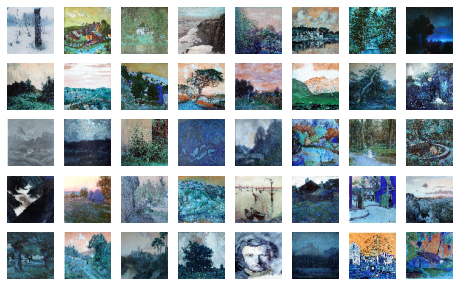

In [ ]:
landscapes = np.asarray(landscapes)

plot_multiple_images(landscapes[:40], n_cols=8)

Image augmentation using a Tensorflow preprocessing pipline

In [ ]:
# data_augmentation = keras.Sequential([
#                                       RandomFlip("horizontal_and_vertical"),
#                                       RandomRotation(0.2)
# ])


In [ ]:
# for i in range(3):

#   aug_list = [None] * len(landscapes)

#   for i in range(len(landscapes)):
#     image = tf.expand_dims(landscapes[i], 0)
#     aug_list[i] = data_augmentation(image)

#   print(type(np.asarray(aug_list)))
#   landscapes = np.concatenate(landscapes, np.asarray(aug_list))

# landscapes_augmented = data_augmentation(landscapes)


# Creating the model

In [ ]:
#Hyperparameters
SAMPLE_SIZE = 1000
BATCH_SIZE = 32
LEAKY_SLOPE = 0.2
DROPOUT = 0.4
CODINGS_SIZE = 128
SCALE = 16

WEIGHT_STD = 0.02
WEIGHT_MEAN = 0
LEARNING_RATE_G = 0.0001
LEARNING_RATE_D = 0.0002

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(landscapes).shuffle(SAMPLE_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
# dataset = dataset.map(lambda x: data_augmentation(x, training=True), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.prefetch(1)

In [ ]:
scaled_size = IMG_SIZE // SCALE
weight_init = tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_STD, mean=WEIGHT_MEAN, seed=42)

Defining custom layers

In [ ]:
def conv_transpose(model, out_channels, k_size, s_size, batch_normalize=True):
  model.add(keras.layers.Conv2DTranspose(out_channels, kernel_size=(k_size, k_size), 
                                         strides=(s_size, s_size), padding='same', use_bias=False,
                                         kernel_initializer=weight_init))
  if batch_normalize is True:
    model.add(keras.layers.BatchNormalization(momentum=0.9))

  #model.add(keras.layers.ReLU())
  model.add(keras.layers.LeakyReLU(LEAKY_SLOPE))

  return model

def conv(model, out_channels, k_size, s_size, batch_normalize=True):
  model.add(keras.layers.Conv2D(out_channels, kernel_size=(k_size, k_size), 
                                strides=(s_size, s_size), padding='same',
                                kernel_initializer=weight_init))
  if batch_normalize is True:
    model.add(keras.layers.BatchNormalization(momentum=0.9))

  model.add(keras.layers.LeakyReLU(LEAKY_SLOPE))

  return model

**Minibatch Discrimination** allows the discriminator to take an entire batch of images and determine at once whether they were made by the generator.

This forces the generator to continue creating images with a wide variety of feature to do its best to fool the discriminator. 

I've noticed that many of the images the generator spits out look very similar to one another, so I'm hoping Minibatch discrimination will help resolve that problem

In [ ]:
def linear(input, output_dim, scope=None, stddev=1.0):
    with tf.compat.v1.variable_scope(scope or 'linear'):

        w = tf.compat.v1.get_variable(
            '__w__w__w__w',
            [input.get_shape()[3], output_dim],
            initializer=tf.random_normal_initializer(stddev=stddev)
        )
        b = tf.compat.v1.get_variable(
            '__b__b__b__b',
            [output_dim],
            initializer=tf.constant_initializer(0.0)
        )

        return tf.matmul(input, w) + b

In [ ]:
def minibatch_discrimination(input, num_kernels=5, kernel_dim=3):

  '''
  I'm running into rank issues where tf.concat refuses to concatenate tensors of
  different ranks. Specifically, it is rejecting concating input [None, 4, 4, 512]
  (rank 4) with minibatch_features [1, 5] (rank 2). I don't think at this point
  in the architecutre that the remaining 4x4 images are super important so I am
  cutting those out to satisfy the rank issue
  '''
  x = linear(input, num_kernels * kernel_dim, scope='minibatch', stddev=0.02)

  activation = tf.reshape(x, (-1, num_kernels, kernel_dim))

  diffs = tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
  abs_diff = tf.reduce_sum(tf.abs(diffs), 2)
  
  minibatch_features = tf.reduce_sum(tf.exp(-abs_diff), 2)

  return tf.concat([input[-1, 3], minibatch_features], 1)

In [ ]:
def generator():
  model = keras.models.Sequential()

  model.add(keras.layers.Dense(scaled_size * scaled_size * 128, input_shape=(CODINGS_SIZE,), kernel_initializer=weight_init))
  model.add(keras.layers.Reshape([scaled_size, scaled_size, 128]))
  
  model = conv_transpose(model, 512, k_size=5, s_size=1)
  model.add(keras.layers.Dropout(DROPOUT))

  model = conv_transpose(model, 256, k_size=5, s_size=2)
  model.add(keras.layers.Dropout(DROPOUT))

  model = conv_transpose(model, 128, k_size=5, s_size=2)
  model.add(keras.layers.Dropout(DROPOUT))

  model = conv_transpose(model, 64, k_size=5, s_size=2)
  model.add(keras.layers.Dropout(DROPOUT))

  model = conv_transpose(model, 32, k_size=5, s_size=2)

  model.add(keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), 
                                         padding='same', activation='tanh', 
                                         use_bias=True, kernel_initializer=weight_init))
  # model.add(keras.layers.Dense(3, activation='tanh', kernel_initializer=weight_init))

  return model

def discriminator():
  model = keras.models.Sequential()

  model.add(keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), 
                              padding='same', activation=keras.layers.LeakyReLU(LEAKY_SLOPE), 
                              input_shape=[64, 64, 3], kernel_initializer=weight_init)) 

  #model.add(keras.layers.Dropout(DROPOUT))
  model = conv(model, 64, k_size=5, s_size=2)

  #model.add(keras.layers.Dropout(DROPOUT))
  model = conv(model, 128, k_size=5, s_size=2)

  #model.add(keras.layers.Dropout(DROPOUT))
  model = conv(model, 256, k_size=5, s_size=2)

  #model.add(keras.layers.Dropout(DROPOUT))
  model = conv(model, 512, k_size=5, s_size=2)

  #model.add(keras.layers.Lambda(minibatch_discrimination))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
generator = generator()
discriminator = discriminator()

gan = keras.models.Sequential([generator, discriminator])

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              264192    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)      

Testing that the models were compiled correctly

The Generator should produce a black box since the weights were normalized to be relatively zero-centered

The Discriminator should predict the generated image with a probability of about 0.5 since it is untrained

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 64, 64, 3)
(1, 128) 0.039112236 0.91619134


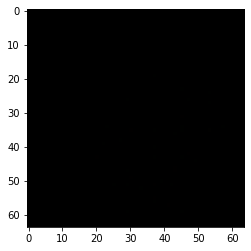

In [ ]:
noise = tf.random.normal([1, CODINGS_SIZE])

generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)
print(noise.shape, tf.math.reduce_mean(noise).numpy(), tf.math.reduce_std(noise).numpy())

In [ ]:
print(discriminator(generated_image))

tf.Tensor([[0.5000186]], shape=(1, 1), dtype=float32)


# Training the Model

**Label Smoothing** prevents the discriminator from being either over confident or underconfident in its predictions.

Essentially if the discriminator is too certain that there is a dog in a given image, the generator can exploit that and contiuously generate similar images, thus it'll stop improving.

This can be combatted by setting the

1. Negative Class labels to a range [0, 0.3]
2. Postitive Class labels to a range [0.7, 1]

**Instance Noise** adds a small amount of error to the labels, which tends to make the true and predicted distributions more spread out.

Instance Noise makes the learning process for the generator easier

ngl idk exactly how this algorithm works, but it does the above

In [ ]:
def smooth_labels(y, label_type):
  if label_type is 'positive':
    return y - 0.3 + (np.random.random(y.shape) * 0.5)
  elif label_type is 'negative':
    return y + np.random.random(y.shape) * 0.3
  else:
    raise ValueError('Expected "positive" or "negative" for label_type. Recieved:', label_type)

def noisy_labels(y, p_flip):
  length = int(y.shape[0])

  num_labels = int(p_flip * length)

  i_flip = np.random.choice([i for i in range(length)], size=num_labels)

  op_list = []
  for i in range(length):
    if i in i_flip:
      op_list.append(tf.subtract(1, y[i]))
    else:
      op_list.append(y[i])

  outputs = tf.stack(op_list)
  return outputs

Both the generator and discriminator will use Adam optimizers, but it is possible that they could end up requiring different learning rate. Thus, we will define a unique optimizer for each of the two

In [ ]:
gen_optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE_G, beta_1=.5)
disc_optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE_D, beta_1=0.5)
#disc_optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_D)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

Defining Loss Functions

Uses Binary Crossentropy to calculate loss.

Discriminator loss: How well the discriminator was able to detect fake images

Generator loss: How well the generator was able to fool the discriminator. We apply positive (1) labels to all generated images to attempt to fool the discriminator

In [ ]:
def discriminator_loss(real_output, fake_output, apply_smoothing=True, apply_noise=True):
  real_output_mod = real_output
  fake_output_mod = fake_output

  if apply_noise:
    real_output_mod = noisy_labels(tf.ones_like(real_output_mod), 0.1)
    fake_output_mod = noisy_labels(tf.zeros_like(fake_output_mod), 0.1)
  
  if apply_smoothing:
    real_output_mod = smooth_labels(real_output_mod, 'positive')
    fake_output_mod = smooth_labels(fake_output_mod, 'negative')

  real_loss = cross_entropy(tf.ones_like(real_output_mod), real_output) #labels, outputs
  fake_loss = cross_entropy(tf.zeros_like(fake_output_mod), fake_output)

  return real_loss + fake_loss

def generator_loss(fake_output, apply_smoothing=True):
  fake_output_mod = fake_output

  if apply_smoothing:
    fake_output_mod = smooth_labels(fake_output_mod, 'negative')

  return cross_entropy(tf.ones_like(fake_output_mod), fake_output)

In [ ]:
def plot_losses(G_loss, D_loss, G_loss_total, D_loss_total, G_mean, D_mean, epoch):
  plt.figure(figsize=(10, 5))
  plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch + 1))
  plt.plot(G_loss, label="Generator")
  plt.plot(D_loss, label="Discriminator")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.legend()
  ymax = plt.ylim()[1]
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(len(G_loss_total)), G_loss_total, label='G')
  plt.plot(np.arange(len(D_loss_total)), D_loss_total, label='D')
  plt.legend()
  plt.title("All Time Loss")
  plt.show()

In [ ]:
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Train_step:

1. Create noise
2. Generate images from noise
3. Feed discriminator real and fake images, record results
4. Calculate loss
5. Calculate gradients
6. Apply gradients
7. Return losses

In [ ]:
def train_step(images):
  noise = tf.random.normal(shape=[BATCH_SIZE, CODINGS_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output, apply_smoothing=True)
    disc_loss = discriminator_loss(real_output, fake_output, apply_smoothing=True, apply_noise=True)

  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  return gen_loss, disc_loss

TODO:

Learning Rate Decay

Experience Replay

Progressive Growth

In [ ]:
plot_step = 1

def train_gan(dataset, epochs=50):
    all_gl = np.array([])
    all_dl = np.array([])
    G_mean = np.array([])
    D_mean = np.array([])

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1, epochs))     

        G_loss = []
        D_loss = []

        for batch in dataset:
            g_loss, d_loss = train_step(batch)
            G_loss.append(g_loss)
            D_loss.append(d_loss)

        all_gl = np.append(all_gl, np.array([G_loss]))
        all_dl = np.append(all_dl, np.array([D_loss]))

        #Generate test images
        noise = tf.random.normal(shape=[BATCH_SIZE, CODINGS_SIZE])
        generated_images = generator(noise, training=False)

        #Save checkpoint
        checkpoint.save(file_prefix = checkpoint_prefix)

        #Print and Plot
        print("Generator Loss Mean:", np.mean(G_loss), "Std:", np.std(G_loss))
        print("Discriminator Loss Mean:", np.mean(D_loss), "Std:", np.std(D_loss))

        G_mean = np.append(G_mean, np.mean(G_loss))
        D_mean = np.append(D_mean, np.mean(D_loss))

        if ((epoch + 1) % plot_step == 0):
          plot_losses(G_loss, D_loss, all_gl, all_dl, G_mean, D_mean, epoch)
          plot_multiple_images(generated_images, 8)                
          plt.show()                                                    

Possible failures:

1. D loss goes to 0: Failure mode
2. If loss of G steadily goes down, it is fooling D with garbage images

Epoch 1/100
Generator Loss Mean: 7.692766 Std: 6.112304
Discriminator Loss Mean: 0.3582695 Std: 0.7935031


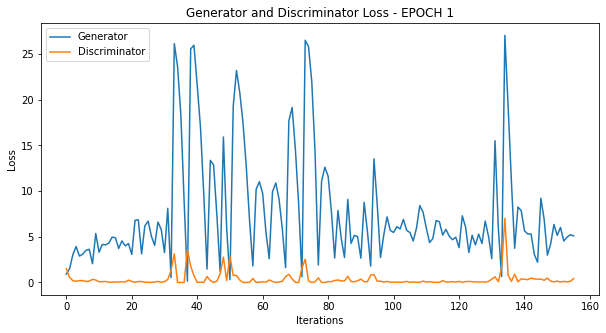

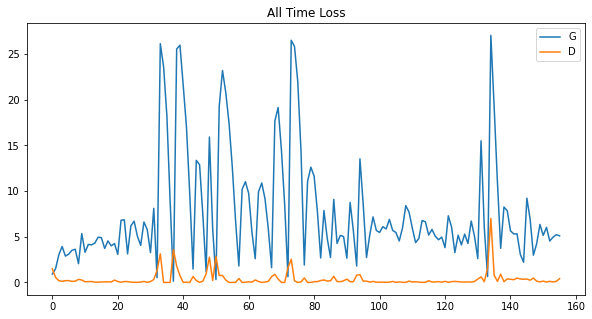

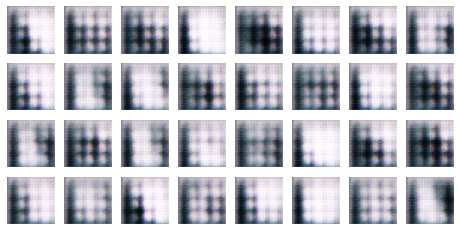

Epoch 2/100
Generator Loss Mean: 3.97859 Std: 1.9693197
Discriminator Loss Mean: 0.4165445 Std: 0.43402025


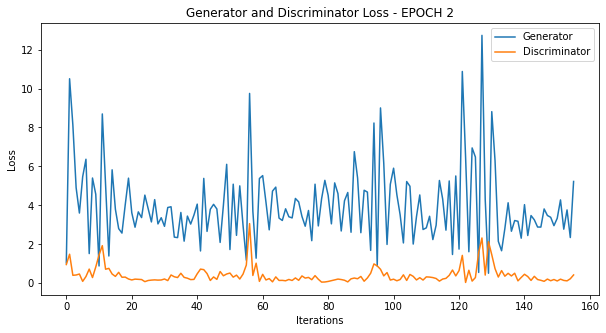

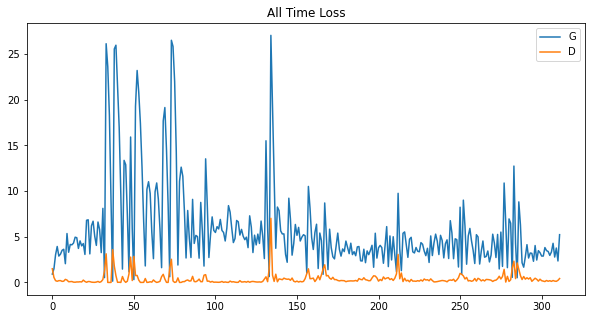

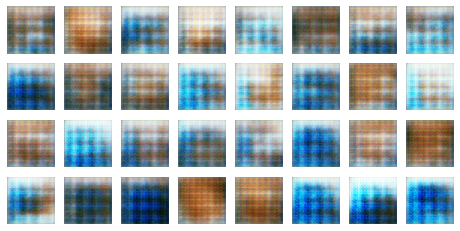

Epoch 3/100
Generator Loss Mean: 3.2279851 Std: 1.9502317
Discriminator Loss Mean: 0.65129566 Std: 0.5930112


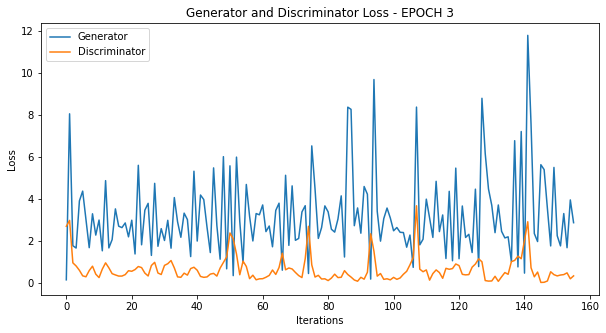

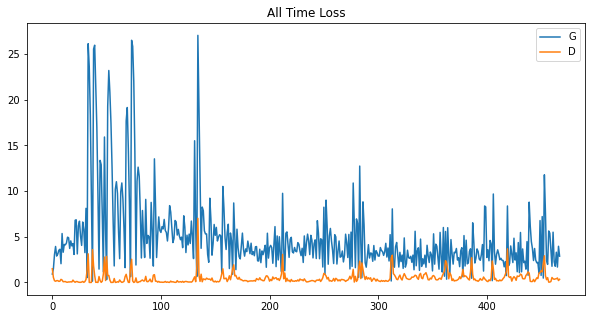

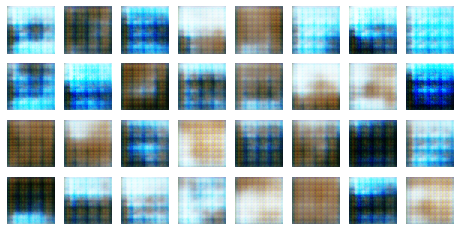

Epoch 4/100
Generator Loss Mean: 3.2673602 Std: 1.9347413
Discriminator Loss Mean: 0.534564 Std: 0.64724076


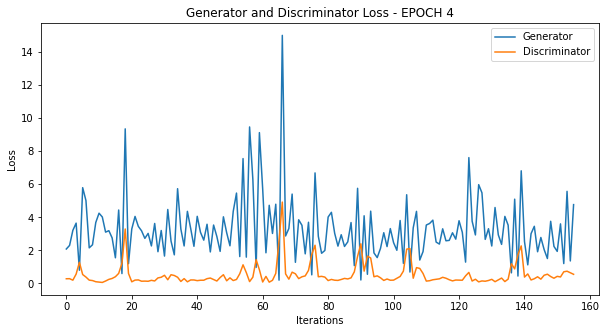

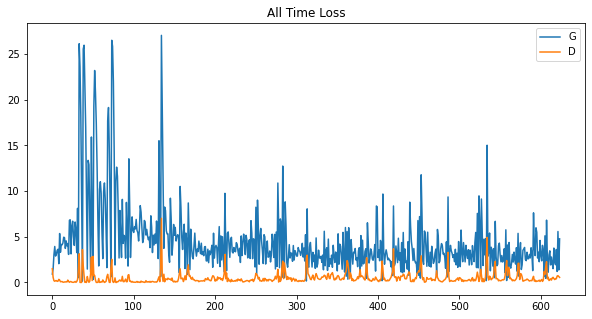

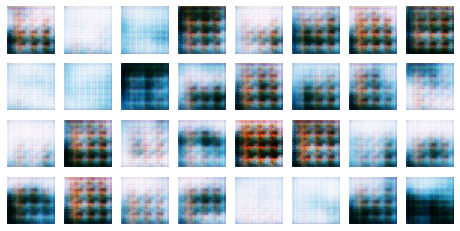

Epoch 5/100


In [ ]:
train_gan(dataset, epochs=100)

Changelog:

1. Removed Dense layer in Generator, lowered batch size from 32 to 16

2. Brought batch size back up to 32, removed all dropout from Generator

3. Put Dropout back in G, lowered D learning rate to .001

4. Removed half of D Dropout, raised G learning rate .002

5. Changed D optimizer from Adam to SGD, lowered G learning rate to .002 raised D learning rate to .002

6. Changed both G and D learning rate to .0002

7. Changed D optimizer back to Adam with .0002 lr

8. Increased G learning rate to .002

9. Increased Dropout to .5, batch size to 64

10. Changed G activation from ReLU to Leaky ReLU

11. Changed G back to ReLU, removed weight_init from all layers

12. Added weight_init back to G

13. Added weight_init back to D, changed G activation function to Leaky ReLU

14. Lowered G lr from .001 to .0002, lowered ksize from 5 to 3

15. Increased ksize from 3 to 7

16. Decreased ksize from 7 to 5

16. Removed all dropout layers in D, added two more dropout layers in G, changed G and D lr to .0001 and .0002 respectively, added beta value of 0.5 to both optimizers (Best change so far)

17. Increased G lr to .0003, increased batch size to 64

18. Decreased G lr to .0001, increased dropout to 0.5 from 0.4

19. Increased sample size to 5000 from 1000

20. Decreased Batch Size from 64 to 32, added checkpoints

21. Changed batch normalization momentum to 0.9